In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Prepare Dataset

In [2]:
train_dataset_path = './dataset/train_preprocess.tsv'
valid_dataset_path = './dataset/valid_preprocess.tsv'
test_dataset_path = './dataset/test_preprocess.tsv'

In [3]:
train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)
test_df = pd.read_csv(test_dataset_path, sep='\t', header=None)

train_df.columns = ['text', 'label']
valid_df.columns = ['text', 'label']
test_df.columns = ['text', 'label']

In [4]:
train_df.head(10)

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [5]:
def get_label_idx(label):
    if label == 'positive':
        return 2
    if label == 'negative':
        return 1
    if label == 'neutral':
        return 0
train_df['label'] = train_df['label'].apply(get_label_idx)
valid_df['label'] = valid_df['label'].apply(get_label_idx)
test_df['label'] = test_df['label'].apply(get_label_idx)

In [6]:
jumlah_positives = (train_df['label'] == 2).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (train_df['label'] == 1).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 6416
Jumlah review negatif: 3436


In [7]:
train_df.head(10)

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,2
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0
2,lokasi strategis di jalan sumatera bandung . t...,2
3,betapa bahagia nya diri ini saat unboxing pake...,2
4,duh . jadi mahasiswa jangan sombong dong . kas...,1
5,"makanan beragam , harga makanan di food stall ...",2
6,pakai kartu kredit bca tidak untung malah rugi...,1
7,"tempat unik , bagus buat foto , makanan enak ,...",2
8,saya bersama keluarga baru saja menikmati peng...,2
9,bersyukur,2


## Preprocessing

In [8]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('indonesian'))
print(len(stop_words))

print (stop_words)

757
{'secara', 'bekerja', 'meski', 'seenaknya', 'karena', 'pertanyakan', 'datang', 'beginilah', 'keseluruhan', 'kalian', 'apalagi', 'ditunjuki', 'oleh', 'tandas', 'kalaulah', 'sebetulnya', 'seolah', 'setiba', 'minta', 'tutur', 'di', 'berlangsung', 'biasa', 'berkata', 'dikarenakan', 'kepada', 'hari', 'mengerjakan', 'setiap', 'diantara', 'tentulah', 'akulah', 'tuturnya', 'sebelum', 'dari', 'justru', 'mengungkapkan', 'sering', 'beginian', 'pertama-tama', 'mengapa', 'sayalah', 'cukupkah', 'umumnya', 'setengah', 'merasa', 'serta', 'seingat', 'apa', 'baru', 'pula', 'sehingga', 'jauh', 'memberi', 'tadi', 'tapi', 'itulah', 'selain', 'setempat', 'diri', 'itu', 'tepat', 'ditanyakan', 'semacam', 'selalu', 'sekurang-kurangnya', 'jelas', 'terutama', 'dekat', 'berikutnya', 'bahkan', 'ditunjukkannya', 'ternyata', 'dibuat', 'tegasnya', 'waduh', 'memperlihatkan', 'sesuatu', 'ini', 'waktu', 'sebaliknya', 'berkali-kali', 'diperbuatnya', 'cukup', 'tidaklah', 'diminta', 'keinginan', 'kamulah', 'mungkinkah'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text): 
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long 
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

# hapus karakter yang tidak dikenal
def clean_review(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  #hapus tanda baca
  text = re.sub(r'[^\w\s]','',text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text


In [11]:

from nltk.tokenize import word_tokenize 

# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)



In [10]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()


def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.text = df_pp.text.map(clean_review)

  # hapus stop words
  df_pp.text = df_pp.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

  # Stemming menggunakan library Sastrawi
  df_pp['text'] = df_pp['text'].apply(lambda x: stemmer.stem(x))
  

  # delete empty row
  df_pp.text.replace('', np.nan, inplace=True)
  df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp.dropna(subset=['text'], inplace=True)
  return df_pp

train_df_preprocessed = preprocess_v1(train_df)

train_df_preprocessed.head(10)

0        warung dimiliki pengusaha pabrik puluhan terke...
1        mohon ulama lurus k mmbri hujjah partai diwlh ...
2        lokasi strategis jalan sumatera bandung nya ny...
3        betapa bahagia nya unboxing paket barang nya b...
4        duh mahasiswa sombong kasih kartu kuning belaj...
                               ...                        
10995                                               kecewa
10996    enak masakan nya kepiting menyenangkan memilih...
10997                      hormati partaipartai berkoalisi
10998      pagi pagi tol pasteur macet parah bikin jengkel
10999    belanja yogya riau junction kali lihat foodlif...
Name: text, Length: 11000, dtype: object


KeyboardInterrupt: 

In [248]:
valid_df_preprocessed = preprocess_v1(valid_df)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13492\2342089784.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pp.text.replace('', np.nan, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_13492\2342089784.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [249]:
# valid_df_preprocessed.to_csv('valid_preprocess.csv', index=False)

In [239]:
# train_df_preprocessed.to_csv('train_preprocessed.csv', index=False)


## TFiDF

In [250]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=16000, min_df=1,
                        norm='l2', ngram_range=(1,2))
train_input = vectorizer.fit_transform(train_df_preprocessed['text']).toarray()
valid_input = vectorizer.transform(valid_df_preprocessed['text']).toarray()
test_input = vectorizer.transform(test_df['text']).toarray()

In [251]:
len(vectorizer.get_feature_names_out()), vectorizer.get_feature_names_out()[0:20]

(16000,
 array(['aa', 'abad', 'abai', 'abalabal', 'abang', 'abc', 'abdi', 'abdul',
        'abdul somad', 'abis', 'abis nya', 'absen', 'abu', 'abuabu',
        'abuba', 'abuba steak', 'ac', 'ac nya', 'acar', 'acara'],
       dtype=object))

In [252]:
train_input.shape

(10993, 16000)

In [ ]:
def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0

## Build and Compile Model

In [264]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [265]:

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_dim=train_input.shape[1], activation='relu'),
    # tf.keras.layers.Dense(64,  activation='relu'),
    tf.keras.layers.Dense(16,  activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')

])

model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_89 (Dense)                │ (None, 32)                │    512,032 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_90 (Dense)                │ (None, 16)                │        528 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_2 (Dropout)             │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_91 (Dense)                │ (None, 3)                 │         51 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 512,611 (1.96 MB)

 Trainable params: 512,611 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [266]:
# model.fit(
#         batch_generator(train_input, train_df['label'], 32),
#         epochs=5, 
#         validation_data=(valid_input, valid_df['label'],),
#        )

# Melatih model
history = model.fit(train_input, train_df_preprocessed['label'],
                    epochs=5, 
                    validation_data=(valid_input, valid_df_preprocessed['label']))

Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6358 - loss: 0.8242 - val_accuracy: 0.8460 - val_loss: 0.4278
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8881 - loss: 0.3229 - val_accuracy: 0.8603 - val_loss: 0.3737
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9546 - loss: 0.1603 - val_accuracy: 0.8556 - val_loss: 0.3993
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9646 - loss: 0.1116 - val_accuracy: 0.8500 - val_loss: 0.4529
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9748 - loss: 0.0762 - val_accuracy: 0.8492 - val_loss: 0.5085


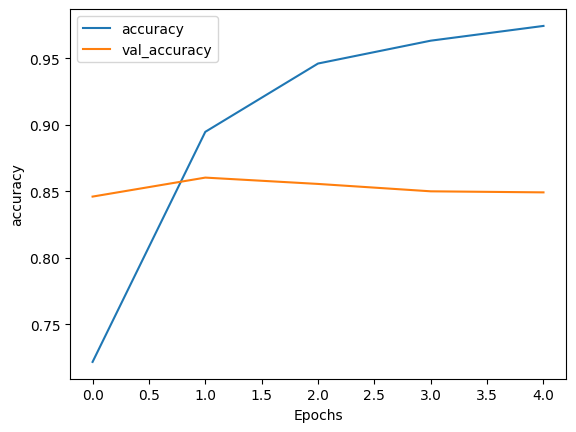

In [267]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

In [270]:
# Konversi probabilitas menjadi label sentimen
def convert_to_sentiment_label(probabilities):
    # Tentukan indeks dengan probabilitas tertinggi
    max_prob_index = np.argmax(probabilities)

    # Definisikan kelas sentimen berdasarkan indeks probabilitas tertinggi
    if max_prob_index == 0:
        return "Netral"
    elif max_prob_index == 1:
        return "Negatif"
    else:
        return "Positif"
    
# Kalimat untuk diuji
sentence = "ngentot lu jokowi"

# Lakukan transformasi TF-IDF pada kalimat
sentence_vectorized = vectorizer.transform([sentence]).toarray()

# Lakukan prediksi sentimen menggunakan model yang telah dilatih
prediction = model.predict(sentence_vectorized)    

# Konversi probabilitas menjadi label sentimen
sentiment_label = convert_to_sentiment_label(prediction[0])

# Tampilkan hasil prediksi
print("Sentimen:", sentiment_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sentimen: Negatif
